In [25]:
import os
import sys
import rrdtool
import pickle
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import HourLocator, DateFormatter
from auserverdata.preparation.rrd import (
    parse_rrds_for_all_collectd_servers,
    parse_rrds_for_all_snmp_servers,
    get_time_series_data_for_collectd_servers,
    get_time_series_data_for_snmp_servers,
    get_feature_names_for_timestamp_set,
    get_feature_names_with_substring_present,
    map_feature_names_to_timestamps,
    map_timestamp_sets_to_feature_names,
    print_timestamp_set_to_feature_names_map_info
)
from auserverdata.local import get_local_config
from auserverdata.analysis import (
    plot_time_series_data_on_single_plot,
    plot_time_series_data_in_vertical_stack
)
from joblib import Parallel,delayed
import pyarrow.parquet as pq
import pyarrow.compute as pc
import xgboost as xgb
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

In [3]:
local_config = get_local_config()

In [4]:
collectd_ts_df = get_time_series_data_for_collectd_servers(rrd_dir=local_config.rrd_dir, collectd_servers=['gpu1'])

In [5]:
timestamps_per_feature_name = map_feature_names_to_timestamps(collectd_ts_df)
feature_names_per_timestamp_set = map_timestamp_sets_to_feature_names(timestamps_per_feature_name)

In [6]:
print_timestamp_set_to_feature_names_map_info(feature_names_per_timestamp_set)

************************************************************
Info about Timestamp Set 0
    Number of timestamps: 1200
    Number of features with the these timestamps: 225
    Step size between timestamps: 0 days 00:00:10
    Start timestamp: 2023-05-20 00:51:28
    End timestamp: 2023-05-20 04:11:18
    Total duration: 0 days 03:19:50
************************************************************
Info about Timestamp Set 1
    Number of timestamps: 1200
    Number of features with the these timestamps: 8
    Step size between timestamps: 0 days 00:00:10
    Start timestamp: 2023-05-20 00:51:33
    End timestamp: 2023-05-20 04:11:23
    Total duration: 0 days 03:19:50
************************************************************
Info about Timestamp Set 2
    Number of timestamps: 1200
    Number of features with the these timestamps: 1
    Step size between timestamps: 0 days 00:00:10
    Start timestamp: 2020-07-09 14:49:41
    End timestamp: 2020-07-09 18:09:31
    Total duration: 0 d

In [7]:
feature_names = get_feature_names_for_timestamp_set(feature_names_per_timestamp_set,0)

In [8]:
collectd_ts_df[feature_names].dropna()

server                  gpu1                                               \
component              cpu-0                                                
rrd                 cpu-idle cpu-interrupt cpu-nice cpu-softirq cpu-steal   
data_source            value         value    value       value     value   
time                                                                        
2023-05-20 00:51:28    99.70           0.0      0.0        0.00       0.0   
2023-05-20 00:51:38    99.72           0.0      0.0        0.00       0.0   
2023-05-20 00:51:48    99.78           0.0      0.0        0.00       0.0   
2023-05-20 00:51:58    99.68           0.0      0.0        0.00       0.0   
2023-05-20 00:52:08    99.62           0.0      0.0        0.00       0.0   
...                      ...           ...      ...         ...       ...   
2023-05-20 04:10:38    99.70           0.0      0.0        0.08       0.0   
2023-05-20 04:10:48    99.66           0.0      0.0        0.00       0.0   
2023-05-20 04:10:58    95.64           0.0      0.0        0.00       0.0   
2023-05-20 04:11:08    84.08           0.0      0.0        0.00       0.0   
2023-05-20 04:11:18    99.60           0.0      0.0        0.00       0.0   

server                                                                   ...  \
component                                           cpu-1                ...   
rrd                 cpu-system cpu-user cpu-wait cpu-idle cpu-interrupt  ...   
data_source              value    value    value    value         value  ...   
time                                                                     ...   
2023-05-20 00:51:28       0.02     0.02     0.12   100.00           0.0  ...   
2023-05-20 00:51:38       0.08     0.08     0.18    99.98           0.0  ...   
2023-05-20 00:51:48       0.02     0.00     0.10    99.92           0.0  ...   
2023-05-20 00:51:58       0.10     0.02     0.10   100.00           0.0  ...   
2023-05-20 00:52:08       0.10     0.08     0.12    99.98           0.0  ...   
...                        ...      ...      ...      ...           ...  ...   
2023-05-20 04:10:38       0.02     0.02     0.10    99.92           0.0  ...   
2023-05-20 04:10:48       0.10     0.08     0.10    99.96           0.0  ...   
2023-05-20 04:10:58       0.12     0.00     3.98    99.78           0.0  ...   
2023-05-20 04:11:08       0.18     0.00    15.64    99.74           0.0  ...   
2023-05-20 04:11:18       0.08     0.00     0.18    99.90           0.0  ...   

server                                                                       \
component           interface-lo      load                           memory   
rrd                   if_packets      load                  memory-buffered   
data_source                   tx shortterm midterm longterm           value   
time                                                                          
2023-05-20 00:51:28          0.0     0.174   0.398    0.470       3100672.0   
2023-05-20 00:51:38          0.0     0.146   0.388    0.468       3100672.0   
2023-05-20 00:51:48          0.0     0.126   0.376    0.460       3100672.0   
2023-05-20 00:51:58          0.0     0.106   0.358    0.458       3100672.0   
2023-05-20 00:52:08          0.0     0.088   0.348    0.450       3100672.0   
...                          ...       ...     ...      ...             ...   
2023-05-20 04:10:38          0.0     0.184   0.288    0.430       3100672.0   
2023-05-20 04:10:48          0.0     0.156   0.278    0.430       3100672.0   
2023-05-20 04:10:58          0.0     0.136   0.268    0.428       3100672.0   
2023-05-20 04:11:08          0.0     0.132   0.262    0.420       3100672.0   
2023-05-20 04:11:18          0.0     0.206   0.274    0.422       3100672.0   

server                                                            \
component                                                          
rrd                 memory-cached   memory-free memory-slab_recl   
data_source      

In [10]:
cpu_feature_names = get_feature_names_with_substring_present(feature_names,'cpu')

### Data Preparation

The CPU features for GPU1 have timestamps 2 seconds after the CPU Temperature feature. The below sets all features to have the timestamps of the CPU Usage features. There are 1200 datapoints in the data, each separated by 10 seconds. 

In [11]:
df1 = collectd_ts_df[cpu_feature_names].dropna()
df1.columns = ['/'.join(col) for col in df1.columns]
df2 = collectd_ts_df['gpu1']['ipmi']['temperature-CPU1 Temp processor (3.1)'].dropna()
df1['temperature-CPU1 Temp processor (3.1)'] = df2.values
columns_to_drop = [col for col in df1.columns if df1[col].nunique() == 1]
df1.drop(columns=columns_to_drop, inplace=True)

In [68]:
x = df1.iloc[:, :-1]
y = df2.iloc[:, -1]

In [52]:
# Normalize
x=(x-x.mean())/x.std()

In [69]:
# Train Test Splits
n_training_points = 1170
x_train = x.iloc[:n_training_points,:]
y_train = y.iloc[:n_training_points]
x_test = x.iloc[n_training_points + 1:,:]
y_test = y.iloc[n_training_points + 1:]

### XGBRegressor

In [66]:
model = xgb.XGBRegressor(n_estimators = 100)
model.fit(x_train,y_train);
y_test_pred = model.predict(x_test)
print(mean_absolute_error(y_test, y_test_pred))

0.6223803816170527


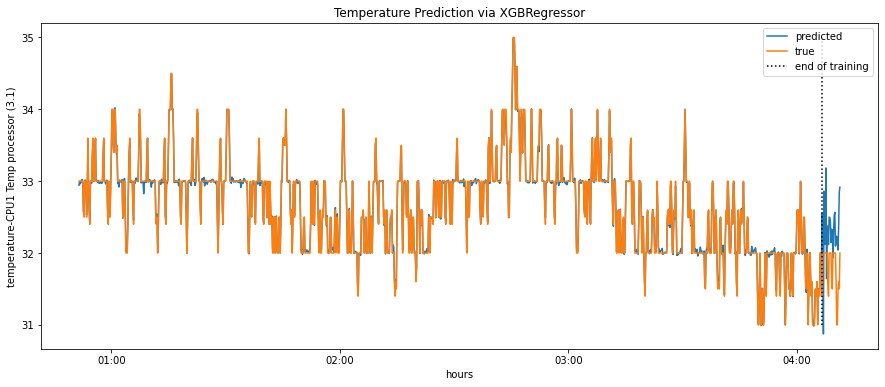

In [67]:
fig, ax = plt.subplots(figsize=(15,6))
timestamps = [pd.to_datetime(x) for x in list(df1.iloc[:, :-1].index)]
plt.plot(timestamps, model.predict(x), label = 'predicted')
plt.plot(timestamps, y, label = 'true')
plt.title('Temperature Prediction via XGBRegressor')
plt.ylabel('temperature-CPU1 Temp processor (3.1)')
plt.vlines(x = [timestamps[n_training_points]], ymin = 31, ymax = 35, linestyles='dotted', color = 'black', label='end of training')
plt.xlabel('hours')
# Set the x-axis locator to show hours
ax.xaxis.set_major_locator(HourLocator(interval=1))  # This sets the tick interval to 1 hour

# Format the x-axis tick labels as hour:minute
ax.xaxis.set_major_formatter(DateFormatter('%H:%M'))
plt.legend()

In [15]:
feature_weights = model.get_booster().get_score(importance_type='weight')

In [17]:
important_feature_indices = [x.replace('f','') for x in list(feature_weights.keys())]

### Neural Forecasting

In [20]:
# Define the LSTM model
model = Sequential()

# Add an LSTM layer
model.add(LSTM(units=64, return_sequences=False))
# Add a Dense output layer (you can adjust the number of units as needed)
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [21]:
model.summary()

ValueError: This model has not yet been built. Build the model first by calling `build()` or by calling the model on a batch of data.

In [50]:
model.fit(x_train, y_train, epochs=20, batch_size=32, validation_data=(x_test, y_test))

Epoch 1/20


35/35 [==============================] - 2s 33ms/step - loss: 885.3566 - val_loss: 588.0540
Epoch 2/20
35/35 [==============================] - 1s 28ms/step - loss: 521.4236 - val_loss: 396.7949
Epoch 3/20
35/35 [==============================] - 1s 27ms/step - loss: 382.3892 - val_loss: 296.3107
Epoch 4/20
35/35 [==============================] - 1s 27ms/step - loss: 290.6520 - val_loss: 222.0075
Epoch 5/20
35/35 [==============================] - 1s 28ms/step - loss: 220.9729 - val_loss: 165.0653
Epoch 6/20
35/35 [==============================] - 1s 28ms/step - loss: 166.7829 - val_loss: 121.0494
Epoch 7/20
35/35 [==============================] - 1s 28ms/step - loss: 124.5025 - val_loss: 87.2423
Epoch 8/20
35/35 [==============================] - 1s 28ms/step - loss: 91.7566 - val_loss: 61.5871
Epoch 9/20
35/35 [==============================] - 1s 29ms/step - loss: 66.6603 - val_loss: 42.4415
Epoch 10/20
35/35 [==============================] - 1s 28ms/step - loss: 47.6841 - val_l

38/38 [==============================] - 0s 7ms/step


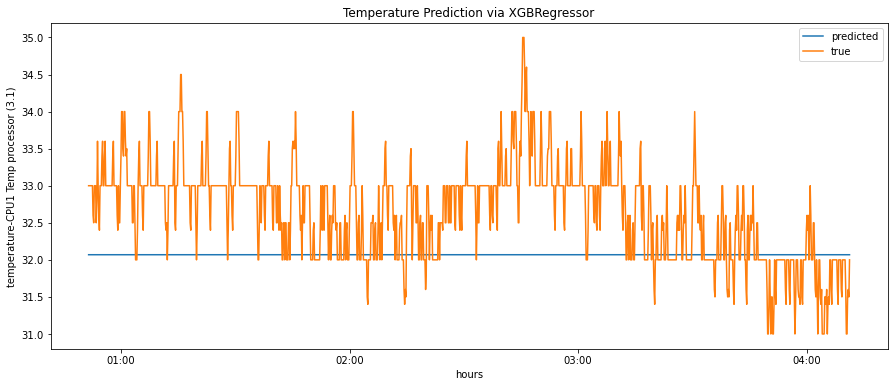

In [52]:
fig, ax = plt.subplots(figsize=(15,6))
timestamps = [pd.to_datetime(x) for x in list(df1.iloc[:, :-1].index)]
plt.plot(timestamps, model.predict(x), label = 'predicted')
plt.plot(timestamps, y, label = 'true')
plt.title('Temperature Prediction via XGBRegressor')
plt.ylabel('temperature-CPU1 Temp processor (3.1)')
plt.xlabel('hours')
# Set the x-axis locator to show hours
ax.xaxis.set_major_locator(HourLocator(interval=1))  # This sets the tick interval to 1 hour

# Format the x-axis tick labels as hour:minute
ax.xaxis.set_major_formatter(DateFormatter('%H:%M'))
plt.legend()